<a href="https://colab.research.google.com/github/papasanimohansrinivas/detr_finetuning_on_fire_data/blob/main/Welcome_to_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

1.6.0+cu101 True


In [3]:
%cd /content/

!rm -rf detr
!git clone https://github.com/woctezuma/detr.git

%cd detr/

!git checkout finetune

/content
Cloning into 'detr'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 239 (delta 6), reused 10 (delta 5), pack-reused 225
Receiving objects: 100% (239/239), 291.17 KiB | 1.09 MiB/s, done.
Resolving deltas: 100% (127/127), done.
/content/detr
Branch 'finetune' set up to track remote branch 'finetune' from 'origin'.
Switched to a new branch 'finetune'


In [4]:
ls

d2/         engine.py   main.py    requirements.txt      tox.ini
datasets/   hubconf.py  models/    run_with_submitit.py  util/
Dockerfile  LICENSE     README.md  test_all.py


In [5]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,'detr-r50_no-class-head.pth')

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


In [6]:
ls

d2/                         engine.py   models/               test_all.py
datasets/                   hubconf.py  README.md             tox.ini
detr-r50_no-class-head.pth  LICENSE     requirements.txt      util/
Dockerfile                  main.py     run_with_submitit.py


In [7]:
cd datasets/

/content/detr/datasets


In [8]:
ls


coco_eval.py      coco.py    __init__.py       transforms.py
coco_panoptic.py  custom.py  panoptic_eval.py


In [9]:
cd ..

/content/detr


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
cp -r '/content/drive/My Drive/detr_dataset' ./

In [74]:
first_class_index  = 1
assert(first_class_index in [0, 1])

if first_class_index == 0:

  # There is one class, balloon, with ID n°0.

  num_classes = 1

  finetuned_classes = [
      'balloon',
  ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°1 here.  

else:

  # There is one class, balloon, with ID n°1.
  #
  # However, DETR assumes that indexing starts with 0, as in computer science,
  # so there is a dummy class with ID n°0.
  # Caveat: this dummy class is not the `no_object` class reserved by DETR.

  num_classes = 2

  finetuned_classes = [
      'N/A', 'fire',
  ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°2 here.

print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 1
Parameter num_classes: 2
Fine-tuned classes: ['N/A', 'fire']


In [13]:
cd /content/detr

/content/detr


In [14]:
ls

d2/                         Dockerfile  main.py           run_with_submitit.py
datasets/                   engine.py   models/           test_all.py
detr_dataset/               hubconf.py  README.md         tox.ini
detr-r50_no-class-head.pth  LICENSE     requirements.txt  util/


In [19]:
cat main.py

# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import argparse
import datetime
import json
import random
import time
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model


def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=300, type=int)
    parser.add_argument('--lr_drop', default=200, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
             

In [19]:
!python main.py \
  --dataset_file "coco" \
  --coco_path "/content/detr/detr_dataset" \
  --output_dir "outputs" \
  --resume "detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 10

Not using distributed mode
git:
  sha: e42a3b174d2325c28f82d7114138c755ac7c095a, status: clean, branch: finetune

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='/content/detr/detr_dataset', dataset_file='coco', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=10, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=2, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
number of params: 41279495
loading annotations into memory...
Done (t=0.00s)
creating index..

In [24]:
ls 

d2/                         engine.py   outputs/              test_all.py
datasets/                   hubconf.py  __pycache__/          tox.ini
detr_dataset/               LICENSE     README.md             util/
detr-r50_no-class-head.pth  main.py     requirements.txt
Dockerfile                  models/     run_with_submitit.py


In [25]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip


In [26]:
model

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
       

In [75]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          print(cl)
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [76]:
def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  for threshold in [0.3, 0.4]:
    
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)

    plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled)


In [77]:
ls /content/detr/detr_dataset/train2017/img_(145).jpg

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `ls -F --color /content/detr/detr_dataset/train2017/img_(145).jpg'


In [78]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [79]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

In [80]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [81]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          print(CLASSES)
          text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [82]:
ls /content/detr/detr_dataset/train2017/

'img_(100).jpg'  'img_(86).jpg'   'pic_(189).jpg'    'small_(104).jpg'
'img_(101).jpg'  'img_(87).jpg'   'pic_(190).jpg'    'small_(105).jpg'
'img_(102).jpg'  'img_(88).jpg'   'pic_(191).jpg'    'small_(106).jpg'
'img_(103).jpg'  'img_(89).jpg'   'pic_(192).jpg'    'small_(107).jpg'
'img_(104).jpg'  'img_(90).jpg'   'pic_(193).jpg'    'small_(108).jpg'
'img_(105).jpg'  'img_(91).jpg'   'pic_(194).jpg'    'small_(109).jpg'
'img_(106).jpg'  'img_(92).jpg'   'pic_(195).jpg'    'small_(110).jpg'
'img_(107).jpg'  'img_(93).jpg'   'pic_(196).jpg'    'small_(111).jpg'
'img_(108).jpg'  'img_(94).jpg'   'pic_(197).jpg'    'small_(112).jpg'
'img_(109).jpg'  'img_(95).jpg'   'pic_(198).jpg'    'small_(113).jpg'
'img_(110).jpg'  'img_(96).jpg'   'pic_(199).jpg'    'small_(114).jpg'
'img_(111).jpg'  'img_(97).jpg'   'pic_(200).jpg'    'small_(115).jpg'
'img_(112).jpg'  'img_(98).jpg'   'pic_(201).jpg'    'small_(116).jpg'
'img_(113).jpg'  'img_(99).jpg'   'pic_(202).jpg'    'small_(117).jpg'
'img_(

tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)


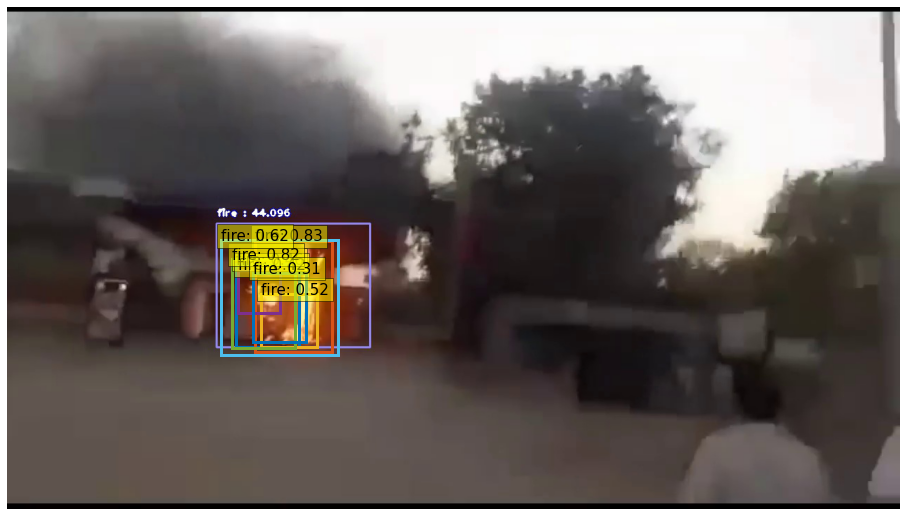

tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)


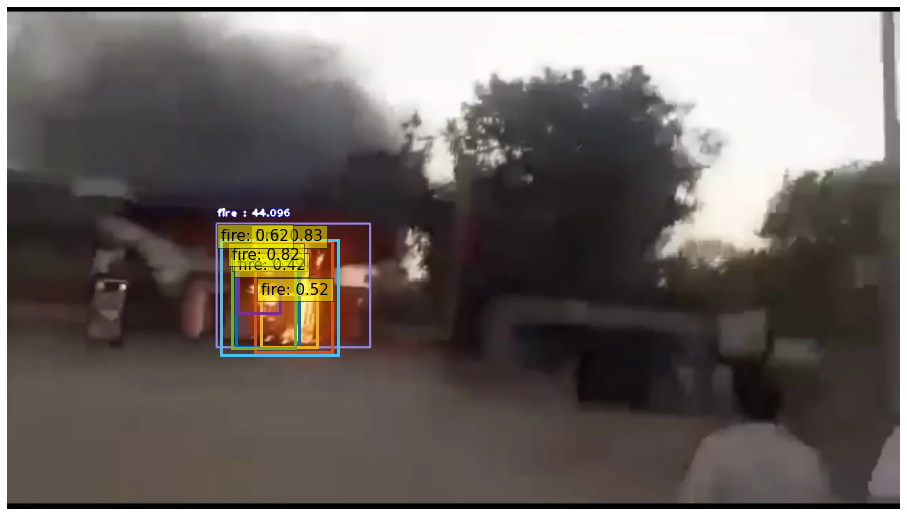

In [89]:

from PIL import Image

# img_name = '/content/detr/detr_dataset/train2017/small_(51).jpg'
# img_name = '/content/Siberian_cctv_200.jpg'
# img_name = '/Siberian_cctv_144.jpg'
img_name = '/content/178.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)

In [73]:
cp  outputs/checkpoint.pth '/content/drive/My Drive/detr_checkpoint'